<a href="https://colab.research.google.com/github/snowman74/Intro_python/blob/master/%D0%9F%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D1%8B%D0%B5%20%D0%B8%20%D1%80%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5%20%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%20%D1%81%D0%B5%D1%82%D0%B8%20%D0%B4%D0%BB%D1%8F%20%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F%20%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85%20%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Прогнозирование акций Лукойла

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -R /content/texts
!unzip -q '/content/drive/My Drive/Базы/20 занятие/акции лукойл-20201011T173155Z-001.zip' -d /content/20_занятие

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
lukoil_df = pd.read_csv('/content/20_занятие/акции лукойл/18_19.csv', sep=';')
lukoil_df.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
base_df16 = pd.read_csv('/content/20_занятие/акции лукойл/16_17.csv', sep=';')
base_df18 = pd.read_csv('/content/20_занятие/акции лукойл/18_19.csv', sep=';')

In [ ]:
df16 = base_df16.iloc[:,2:]
df18 = base_df18.iloc[:,2:]

In [ ]:
data = df16.copy()
data = pd.concat([df16, df18])
data = np.array(data)

In [ ]:
xLen = 300
valLen = 30000

trainLen = data.shape[0] - valLen

xTrain, xTest = data[:trainLen], data[trainLen + xLen + 2:]

xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain, yTest = np.reshape(data[:trainLen,3], (-1,1)), np.reshape(data[trainLen + xLen + 2:,3], (-1,1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen,
                                   stride=1, batch_size=20)

testDataGen = TimeseriesGenerator(xTest, yTest,
                                  length=xLen,
                                  stride=1,
                                  batch_size=20)


In [ ]:
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,5), activation="linear" ))
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
22579/22579 [==============================] - 53s 2ms/step - loss: 0.0040 - val_loss: 5.9440e-05
Epoch 2/20
22579/22579 [==============================] - 52s 2ms/step - loss: 1.4759e-04 - val_loss: 1.4993e-05
Epoch 3/20
22579/22579 [==============================] - 53s 2ms/step - loss: 7.0201e-05 - val_loss: 1.0671e-05
Epoch 4/20
22579/22579 [==============================] - 52s 2ms/step - loss: 3.2541e-05 - val_loss: 9.3927e-06
Epoch 5/20
22579/22579 [==============================] - 52s 2ms/step - loss: 2.3850e-05 - val_loss: 2.4526e-05
Epoch 6/20
22579/22579 [==============================] - 52s 2ms/step - loss: 1.8601e-05 - val_loss: 6.0565e-05
Epoch 7/20
22579/22579 [==============================] - 53s 2ms/step - loss: 1.8954e-05 - val_loss: 1.9952e-05
Epoch 8/20
22579/22579 [==============================] - 52s 2ms/step - loss: 1.7385e-05 - val_loss: 4.1032e-06
Epoch 9/20
22579/22579 [

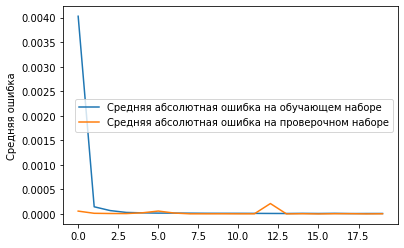

In [ ]:
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)

  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel],
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение close')
  plt.legend()
  plt.show()

def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()

  val = 1
  if ((sa > 0) & (sb > 0)):
    val = (mab - ma * mb)/ (sa * sb)
  return val

def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen - i, ch], predVal[i:, 0]))

    own_corr = []
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen - i, ch], yValUnscaled[i:, ch]))

    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
DataGen = TimeseriesGenerator(xTest, yTest,
                              length=300, stride=1,
                              batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

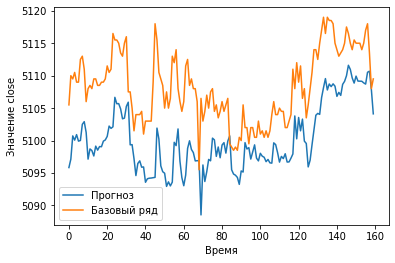

In [ ]:
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

showPredict(0, 160, 0, predVal, yValUnscaled)

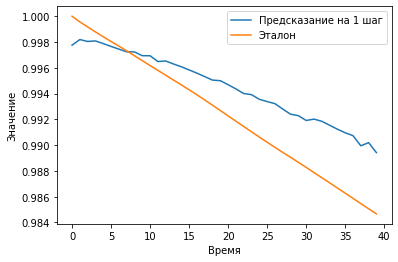

In [ ]:
showCorr([0], 40, predVal, yValUnscaled)

Сделаем несколько усовершенствований в предсказании временного ряда.
Добавим к исходному сигналу расширенные данные:

попарные разности каналов

модули попарных разностей каналов

попарные произведения каналов

обратное значение каналов x_new = 1/(x + 1e-3)

первые производные каналов (x[n] - x[n-1])

вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Сделаем бОльший “просмотр сети в прошлое”, при формировании входного сигнала используем:

100 точек с шагом назад по 1

100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек)


In [ ]:
base_df16 = pd.read_csv('/content/20_занятие/акции лукойл/16_17.csv', sep=';')
base_df18 = pd.read_csv('/content/20_занятие/акции лукойл/18_19.csv', sep=';')

In [ ]:
lukoil_df = pd.concat([base_df16, base_df18])

In [ ]:
lukoil_df.drop(labels=lukoil_df.columns[0], axis=1, inplace=True)

In [ ]:
# (x[n+2] - 2*x[n+1] + x[n])
def second_deriviate(x):
  a = x[2:].values #n+2
  b = x[:-2].values #n
  c = x[1:-1].values #n+1
  ddy = a - 2*c + b
  return np.append(ddy, [0,0])

def deriviate(x):
  a = x[1:].values
  b = x[:-1].values
  dy = a - b
  
  return np.append(dy, 0)

In [ ]:
# Искусственно расширяем базу 
lukoil_df['Open-Max'] = lukoil_df['OPEN'] - lukoil_df['MAX']
lukoil_df['Open-Min'] = lukoil_df['OPEN'] - lukoil_df['MIN']
lukoil_df['Open-Close'] = lukoil_df['OPEN'] - lukoil_df['CLOSE']
lukoil_df['ABS_Open-Max'] = abs(lukoil_df['OPEN'] - lukoil_df['MAX'])
lukoil_df['ABS_Open-Min'] = abs(lukoil_df['OPEN'] - lukoil_df['MIN'])
lukoil_df['ABS_Open-Close'] = abs(lukoil_df['OPEN'] - lukoil_df['CLOSE'])
lukoil_df['Open*Max'] = lukoil_df['OPEN'] * lukoil_df['MAX']
lukoil_df['Open*Min'] = lukoil_df['OPEN'] * lukoil_df['MIN']
lukoil_df['Open*Close'] = lukoil_df['OPEN'] * lukoil_df['CLOSE']
lukoil_df['1/Open'] = 1/lukoil_df['OPEN']
lukoil_df['1/Max'] = 1/lukoil_df['MAX']
lukoil_df['1/Min'] = 1/lukoil_df['MIN']
lukoil_df['1/Close'] = 1/lukoil_df['CLOSE']
lukoil_df['1/Volume'] = 1/lukoil_df['VOLUME']
lukoil_df['diff_Open'] = deriviate(lukoil_df['OPEN'])
lukoil_df['diff_Max'] = deriviate(lukoil_df['MAX'])
lukoil_df['diff_Min'] = deriviate(lukoil_df['MIN'])
lukoil_df['diff_Close'] = deriviate(lukoil_df['CLOSE'])
lukoil_df['diff_Volume'] = deriviate(lukoil_df['VOLUME'])
lukoil_df['2diff_Open'] = second_deriviate(lukoil_df['OPEN'])
lukoil_df['2diff_Max'] = second_deriviate(lukoil_df['MAX'])
lukoil_df['2diff_Min'] = second_deriviate(lukoil_df['MIN'])
lukoil_df['2diff_Close'] = second_deriviate(lukoil_df['CLOSE'])
lukoil_df['2diff_Volume'] = second_deriviate(lukoil_df['VOLUME'])

In [ ]:
lukoil_data = np.array(lukoil_df, dtype='int64')

In [ ]:
lukoil_data

array([[ 2351,  2355,  2350, ...,     1,    -7,  2414],
       [ 2352,  2355,  2350, ...,    -1,     1,   444],
       [ 2355,  2356,  2351, ...,     2,     0, -1038],
       ...,
       [ 5183,  5183,  5183, ...,     0,     0,  1214],
       [ 5183,  5183,  5183, ...,     0,     0,     0],
       [ 5183,  5183,  5183, ...,     0,     0,     0]])

In [ ]:
data.shape

(481872, 5)

In [ ]:
xLen = 300
valLen = 30000

trainLen = lukoil_data.shape[0] - valLen

xTrain, xTest = lukoil_data[:trainLen], lukoil_data[trainLen + xLen + 2:]

xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain, yTest = np.reshape(data[:trainLen,3], (-1,1)), np.reshape(data[trainLen + xLen + 2:,3], (-1,1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen,
                                   stride=1, batch_size=20)

testDataGen = TimeseriesGenerator(xTest, yTest,
                                  length=xLen,
                                  stride=1,
                                  batch_size=20)


In [ ]:
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen, lukoil_data.shape[1]), activation="linear" ))
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

Epoch 1/20
22579/22579 [==============================] - 64s 3ms/step - loss: 0.0049 - val_loss: 2.7152e-05
Epoch 2/20
22579/22579 [==============================] - 64s 3ms/step - loss: 7.2289e-04 - val_loss: 0.0047
Epoch 3/20
22579/22579 [==============================] - 64s 3ms/step - loss: 3.7169e-04 - val_loss: 1.9404e-04
Epoch 4/20
22579/22579 [==============================] - 65s 3ms/step - loss: 2.3989e-04 - val_loss: 6.0488e-05
Epoch 5/20
22579/22579 [==============================] - 65s 3ms/step - loss: 1.4111e-04 - val_loss: 1.3855e-04
Epoch 6/20
22579/22579 [==============================] - 64s 3ms/step - loss: 1.0192e-04 - val_loss: 2.7797e-05
Epoch 7/20
22579/22579 [==============================] - 64s 3ms/step - loss: 6.5902e-05 - val_loss: 0.0072
Epoch 8/20
22579/22579 [==============================] - 64s 3ms/step - loss: 6.0527e-05 - val_loss: 3.5119e-04
Epoch 9/20
22579/22579 [==============================] - 65s 3ms/step - loss: 5.4665e-05 - val_loss: 6.0813

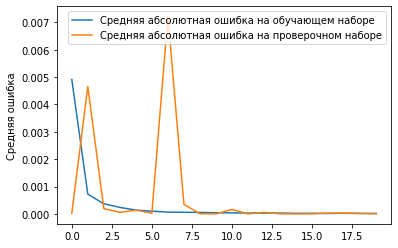

In [ ]:
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
DataGen = TimeseriesGenerator(xTest, yTest,
                              length=300, stride=1,
                              batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

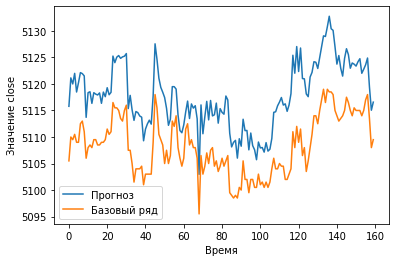

In [ ]:
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

showPredict(0, 160, 0, predVal, yValUnscaled)

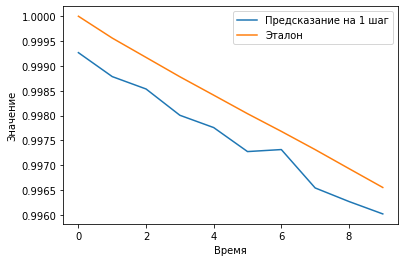

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

Как видно из графика корреляций - автокорреляция отсутствует, а значит расширение данных дало положительный эффект, однако графики сравнения предсказанных и действительных значений дают разницу примерно на 10 пунктов.
Думаю этот показатель можно улучшить, подобрав архитектуру и гиперпараметры. 